In [1]:
import tensorflow as tf
from tensorflow.keras.layers import average, maximum, minimum
import tensorflow_hub as hub
import os
import numpy as np
import tensorflow_hub as hub
import pathlib


from tensorflow import keras
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm



print(tf.__version__)


def read_and_label(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    label = get_label(file_path)
    return img, label


def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.reshape(tf.where(parts[-4] == CLASS_NAMES), [])


def augment(image, label):
    image = tf.image.random_hue(image, max_delta=0.05, seed=5)
    image = tf.image.random_contrast(image, 0.95, 1.05, seed=5)  # tissue quality
    image = tf.image.random_saturation(image, 0.95, 1.05, seed=5)  # stain quality
    image = tf.image.random_brightness(image, max_delta=0.05)  # tissue thickness, glass transparency (clean)
    image = tf.image.random_flip_left_right(image, seed=5)  # cell orientation
    image = tf.image.random_flip_up_down(image, seed=5)  # cell orientation
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # cell orientation
    return image, label


IMG_HEIGHT = 100
IMG_WIDTH = 100
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
shuffle_buffer_size = 1000000


2.2.0


In [2]:
test_data_dir = '/home/kuki/Desktop/Research/cnn_dataset/test'
print(os.listdir(test_data_dir))

['young', 'old']


In [3]:
test_data_dir = pathlib.Path(test_data_dir)
CLASS_NAMES = np.array(
    [item.name for item in test_data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_store"])

In [4]:
#'/home/kuki/Desktop/Research/migrate/'

def load_compile(net):
    print(os.path.exists('cnn/'+ net + '/full_model.h5'))
    model = tf.keras.models.load_model('cnn/'+ net + '/full_model.h5', compile=False,
                                       # custom_objects={'KerasLayer': hub.KerasLayer}
                                       )
    print(model.summary())
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model


ResV2 = load_compile('ResV2')
# IncV3 = load_compile('IncV3')
# IncV3n = load_compile('IncV3n')
ResV2.summary()

True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 2048)              42626560  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 42,630,658
Trainable params: 42,532,994
Non-trainable params: 97,664
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 2048)              42626560  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 42,630,658
Trainable params: 42,532,994
Non-trainable params: 97,664
__________________________________________________________

In [5]:
# IncV3_base = IncV3.get_layer('inception_v3')
# IncV3_base.summary()
ResV2_base = ResV2.get_layer('resnet101v2')
ResV2_dense = ResV2.get_layer('dense')
ResV2_base.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 52, 52, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [6]:
def load_dataset(dataset_dir):
    dataset_dir = pathlib.Path(dataset_dir)
    test_image_count2 = len(list(test_data_dir.glob('image/*.jpg')))
    list_ds = tf.data.Dataset.list_files(str(dataset_dir / 'image/*.jpg'))
    # for f in list_ds.take(5):
    #     print(f.numpy())
    labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
    return labeled_ds, test_image_count2


# def evalmodels(path, model):
#     datasett, datasettsize = load_dataset(path)
#     with tf.device('/device:GPU:1'):
#         results = model.evaluate(datasett.batch(1000))
#     # print(os.path.basename(path), results[-1] * 100)
#     aa.append(np.around(results[-1] * 100, decimals=1))


In [7]:
# from tf_explain.core.grad_cam import GradCAM
# explainer = GradCAM()
# grid = explainer.explain(data, model, class_index=281)  # 281 is the tabby cat index in ImageNet
# explainer.save(grid, ".", "grad_cam.png")

In [8]:
"""
## Configurable parameters
You can change these to another model.
To get the values for `last_conv_layer_name` and `classifier_layer_names`, use
 `model.summary()` to see the names of all layers in the model.
"""

# model_builder = keras.applications.xception.Xception
# img_size = (299, 299)
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions
model_builder = ResV2_base
model = ResV2
img_size = (100, 100)

# last_conv_layer_name = "block14_sepconv2_act"
last_conv_layer_name = "post_relu"

classifier_layer_names = [
    "avg_pool"
]

# The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
# )
img_path = '/home/kuki/Desktop/Research/cnn_dataset/train/young/sec001/image/2.jpg'

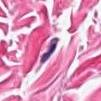

In [9]:
display(Image(img_path))

In [10]:
"""
## The Grad-CAM algorithm
"""


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    # added by kyu
    x = ResV2_dense(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

/home/kuki/anaconda3/envs/TF2Shared/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/kuki/anaconda3/envs/TF2Shared/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/kuki/anaconda3/envs/TF2Shared/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/kuki/anaconda3/envs/TF2Shared/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/kuki/anaconda3/envs/TF2Shared/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/kuki/anaconda3/envs/TF2Shared/lib/python3.7/site-packages/numpy/

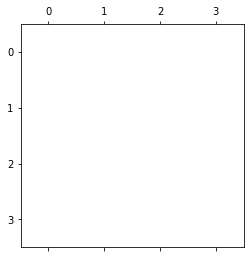

In [11]:
"""
## Let's test-drive it
"""

# Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = get_img_array(img_path, size=img_size)

# Make model
# model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model_builder, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

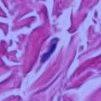

In [12]:
"""
## Create a superimposed visualization
"""

# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
